# ORA
Over-Representation Analysis

# Phase 2 vs. Phase 2

This is the same analysis at the bottom of [gsea_p1.v.p1.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/gsea_p1.v.p1.ipynb), but since there are so many comparisons, I'm splitting these (GSEA and ORA) analyses up in to two different code notebooks (see [gsea_p2.v.p2.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/gsea_p2.v.p2.ipynb) for GSEA).

## 0. load libraries

In [2]:
library(tidyverse)
library(clusterProfiler) # for GSEA()
library(enrichplot) # for enrichment visuals 
library(GO.db) # for gene ontology database
library(UpSetR) # for Cvirginica annotations
library(patchwork) # for arranging multiple plots

## 1. read CSVs
For this analysis, I need a **universal list** (all genes tested) and a **gene list** that contains genes of interest (in this case, DEGs)

#### universal list

In [3]:
universal <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv')$Gene

head(universal)

[1] "LOC111116054" "LOC111126949" "LOC111110729" "LOC111112434" "LOC111120752"
[6] "LOC111128944"

#### DEGs list

In [4]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs',
    pattern = '\\.csv$',
    full.names = TRUE
    )

# read csv and add to vectorized list
names(files) <- gsub("^DEG_", "", tools::file_path_sans_ext(basename(files)))
df_list <- lapply(files, read.csv)
names(df_list)

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

In [5]:
# get list of DEGs for each df
all_df <- lapply(df_list, function(df) {
    geneList <- df$Gene 
})

head(all_df$bb_cc)

[1] "LOC111134671" "LOC111120923" "LOC111136853" "LOC111120760" "LOC111125595"
[6] "LOC111114504"

## 2. create term2gene and term2name

In [6]:
# col1 = gene ID
# col2 = GO ID 
gene2go <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
head(gene2go)

,gene,Gene.Ontology.IDs
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


re-format for correct input for `GSEA()` - two columns, one for GO term and one for gene ID

In [7]:
term2gene <- gene2go %>%
  mutate(GO_terms = strsplit(Gene.Ontology.IDs, ",\\s*|;\\s*|`")) %>%  # Split by comma, semicolon, or backtick
  unnest(GO_terms) %>%
  filter(grepl("^GO:", GO_terms)) %>%  # Keep only valid GO terms
  dplyr::select(term = GO_terms, gene = gene)

class(term2gene)
str(term2gene)
head(term2gene)

[1] "tbl_df"     "tbl"        "data.frame"

tibble [223,103 × 2] (S3: tbl_df/tbl/data.frame)
 $ term: chr [1:223103] "GO:0005042" "GO:0005737" "GO:0008233" "GO:0016020" ...
 $ gene: chr [1:223103] "LOC111126949" "LOC111126949" "LOC111126949" "LOC111126949" ...


term,gene
<chr>,<chr>
GO:0005042,LOC111126949
GO:0005737,LOC111126949
GO:0008233,LOC111126949
GO:0016020,LOC111126949
GO:0043123,LOC111126949
GO:0046330,LOC111126949


get term names for GO IDs

In [8]:
# Extract GO term descriptions
go_terms <- unique(term2gene$term)

# Get descriptions from GO.db
term2name <- data.frame(
  term = go_terms,
  name = sapply(go_terms, function(x) {
    tryCatch({
      Term(GOTERM[[x]])
    }, error = function(e) {
      NA_character_
    })
  })
)

# Remove NAs
term2name <- term2name[!is.na(term2name$name), ]

# View
head(term2name)    

,term,name
,<chr>,<chr>
GO:0005042,GO:0005042,netrin receptor activity
GO:0005737,GO:0005737,cytoplasm
GO:0008233,GO:0008233,peptidase activity
GO:0016020,GO:0016020,membrane
GO:0043123,GO:0043123,positive regulation of canonical NF-kappaB signal transduction
GO:0046330,GO:0046330,positive regulation of JNK cascade


## 3. `enricher`
universal enrichment analyzer from clusterProfiler - hypergeometric test

provide a pre-defined list of interesting genes (DEGs) and comparing against a universal set

### 1. effect of single exposure after period of recovery
- CC vs. WC (no enriched terms)
- CC vs. HC (no enriched terms)
- CC vs. BC

In [20]:
# CC vs. WC
res_sig.cc.wc <- enricher(
    gene = all_df$wc_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

res_sig.cc.wc <- as.data.frame(res_sig.cc.wc)
head(res_sig.cc.wc)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched terms

In [21]:
# CC vs. HC
res_sig.cc.hc <- enricher(
    gene = all_df$hc_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

res_sig.cc.hc <- as.data.frame(res_sig.cc.hc)
head(res_sig.cc.hc)

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched terms

In [22]:
# CC vs. BC
res_sig.cc.bc <- enricher(
    gene = all_df$bc_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

res_sig.cc.bc <- as.data.frame(res_sig.cc.bc)
head(res_sig.cc.bc)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005764,GO:0005764,lysosome,18/179,368/16641,9.495233e-08,8.422271e-05,7.716126e-05,LOC111111564/LOC111125529/LOC111119850/LOC111125418/LOC111129386/LOC111129385/LOC111129849/LOC111128921/LOC111134948/LOC111135087/LOC111135238/LOC111133671/LOC111100764/LOC111103198/LOC111103450/LOC111108482/LOC111109438/LOC111109436,18


comparing to [gsea analysis](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/gsea_p2.v.p2.ipynb) - GSEA seemed to be more sensitive (identifying more enriched terms/pathways) with more specific terms (lysosome here vs. binding and structural processes in GSEA)

### 2. Effect of single exposure only experienced later in life
- CC vs. CW
- CC vs. CH (no enriched terms)
- CC vs. CB

In [16]:
# CC vs. CW
res_sig.cc.cw <- enricher(
    gene = all_df$cw_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.cw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0010650,GO:0010650,positive regulation of cell communication by electrical coupling,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:0034112,GO:0034112,positive regulation of homotypic cell-cell adhesion,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:0043266,GO:0043266,regulation of potassium ion transport,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:0099612,GO:0099612,protein localization to axon,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:1900827,GO:1900827,positive regulation of membrane depolarization during cardiac muscle cell action potential,3/27,43/16641,4.501658e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111107865,3
GO:0007409,GO:0007409,axonogenesis,4/27,126/16641,4.804862e-05,0.0008904254,0.0004429977,LOC111100764/LOC111108482/LOC111109183/LOC111107865,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


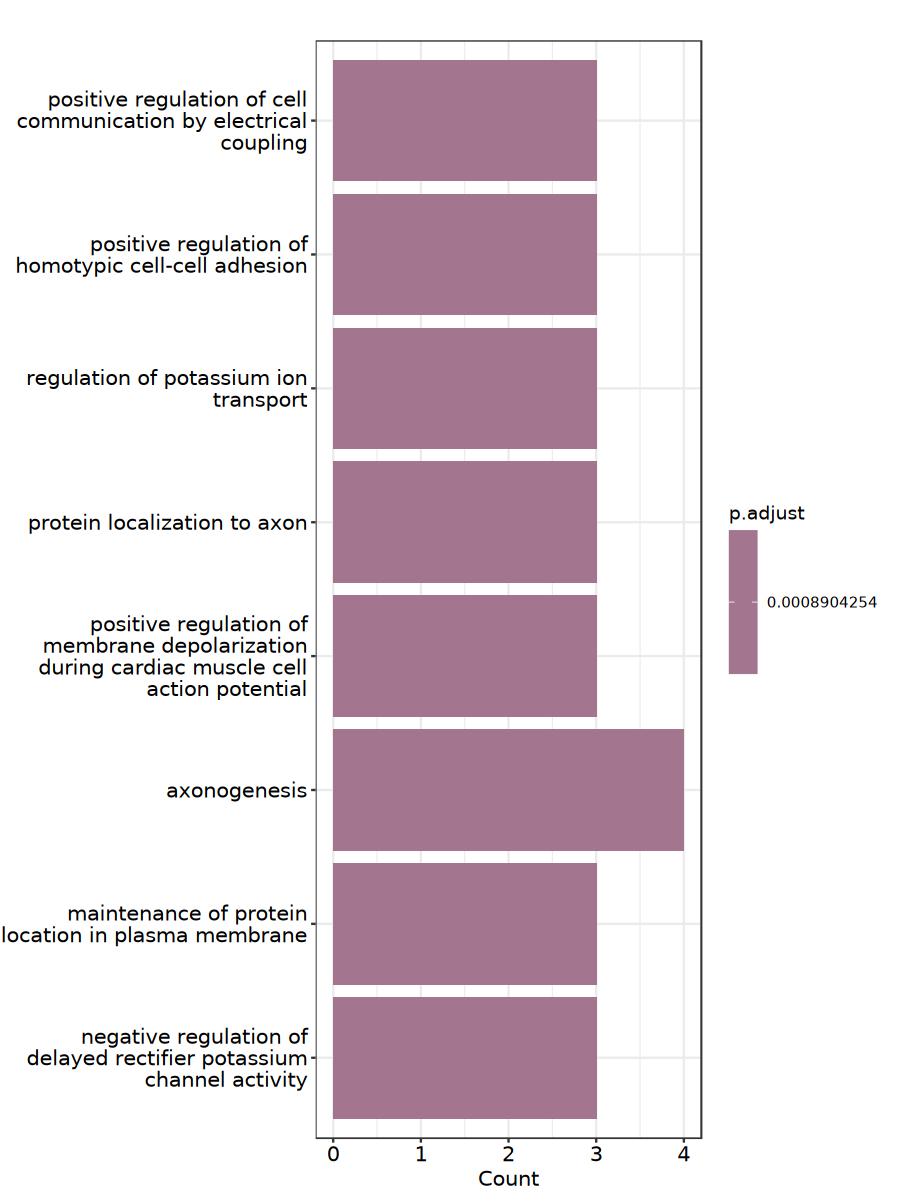

In [30]:
options(repr.plot.width=7.5, repr.plot.height=10)

barplot(res_sig.cc.cw)

looks like some terms involved in signalling (cell-cell adhesion, communication) but also some terms related to neurons

In [20]:
# CC vs. CH
res_sig.cc.ch <- enricher(
    gene = all_df$ch_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.ch))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched/over-represented GO terms

In [21]:
# CC vs. CB
res_sig.cc.cb <- enricher(
    gene = all_df$cb_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.cb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0051537,GO:0051537,"2 iron, 2 sulfur cluster binding",3/51,35/16641,0.0001656261,0.03657174,0.02643594,LOC111123314/LOC111127059/LOC111126872,3
GO:0016491,GO:0016491,oxidoreductase activity,5/51,182/16641,0.0002314667,0.03657174,0.02643594,LOC111127059/LOC111137386/LOC111137388/LOC111136642/LOC111106942,5
GO:0055078,GO:0055078,sodium ion homeostasis,2/51,10/16641,0.0004079407,0.03694942,0.02670894,LOC111118161/LOC111118627,2
GO:0044325,GO:0044325,transmembrane transporter binding,5/51,231/16641,0.0006893266,0.03694942,0.02670894,LOC111133968/LOC111100764/LOC111108482/LOC111110117/LOC111113824,5
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,4/51,135/16641,0.0007704427,0.03694942,0.02670894,LOC111133968/LOC111100764/LOC111108482/LOC111113824,4
GO:0015385,GO:0015385,sodium:proton antiporter activity,2/51,14/16641,0.0008184997,0.03694942,0.02670894,LOC111118161/LOC111118627,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


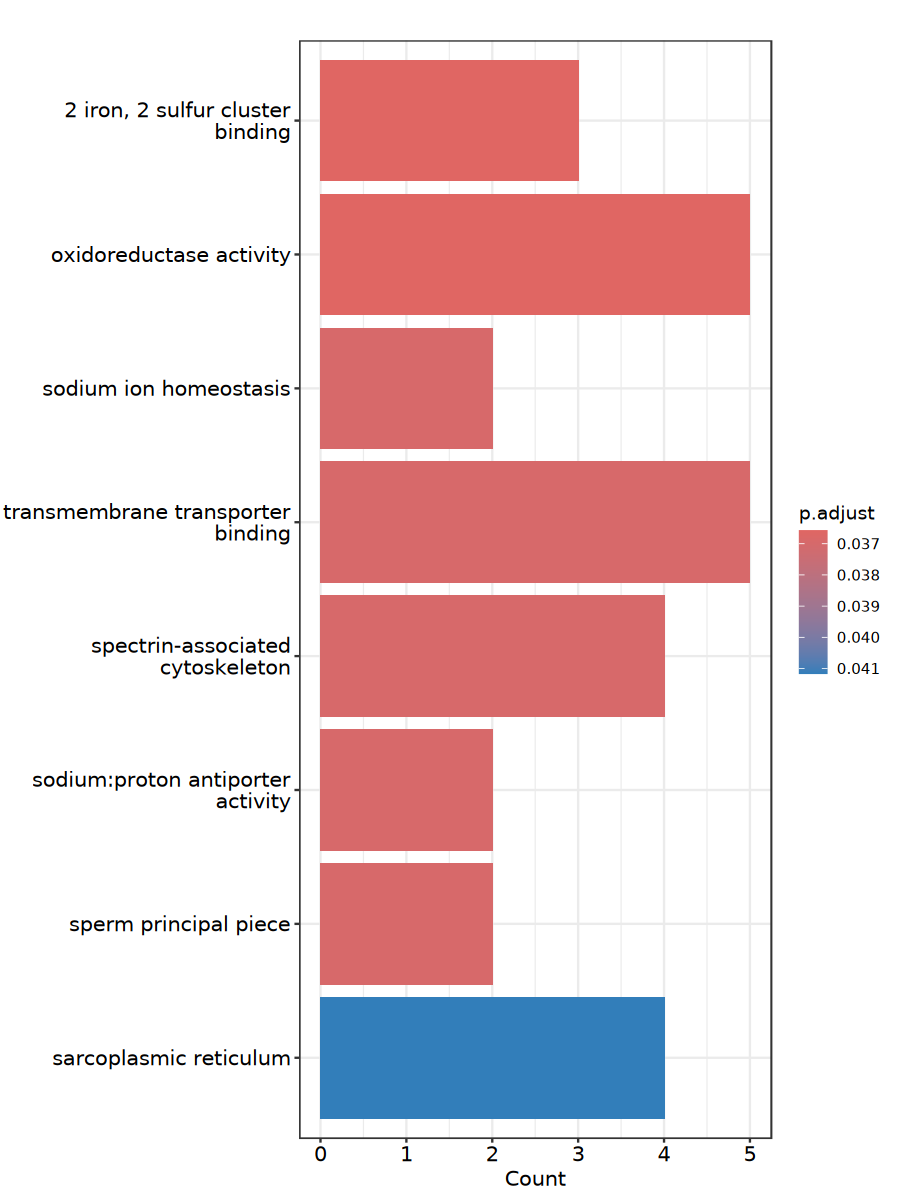

In [31]:
barplot(res_sig.cc.cb)

see terms related to structural processes  (cyotskeleton) but also see oxidoreductase which is involved in redox reactions (vital for metabolism and energy production)

### 3. Effect of timing of initial stress exposure
- WC vs. CW
- HC vs. CH
- BC vs. CB

In [32]:
# WC vs. CW
res_sig.wc.cw <- enricher(
    gene = all_df$cw_wc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wc.cw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0008093,GO:0008093,cytoskeletal anchor activity,6/41,121/16641,4.764237e-07,0.0001080404,6.211965e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,6/41,135/16641,9.079026e-07,0.0001080404,6.211965e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0016529,GO:0016529,sarcoplasmic reticulum,6/41,154/16641,1.960415e-06,0.0001493782,8.588753e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0030507,GO:0030507,spectrin binding,6/41,161/16641,2.538419e-06,0.0001493782,8.588753e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0005200,GO:0005200,structural constituent of cytoskeleton,6/41,167/16641,3.138198e-06,0.0001493782,8.588753e-05,LOC111100764/LOC111107865/LOC111112084/LOC111113824/LOC111113858/LOC111110817,6
GO:0070469,GO:0070469,respirasome,3/41,13/16641,3.902754e-06,0.0001548092,8.901017e-05,LOC111119097/LOC111119236/LOC111125731,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


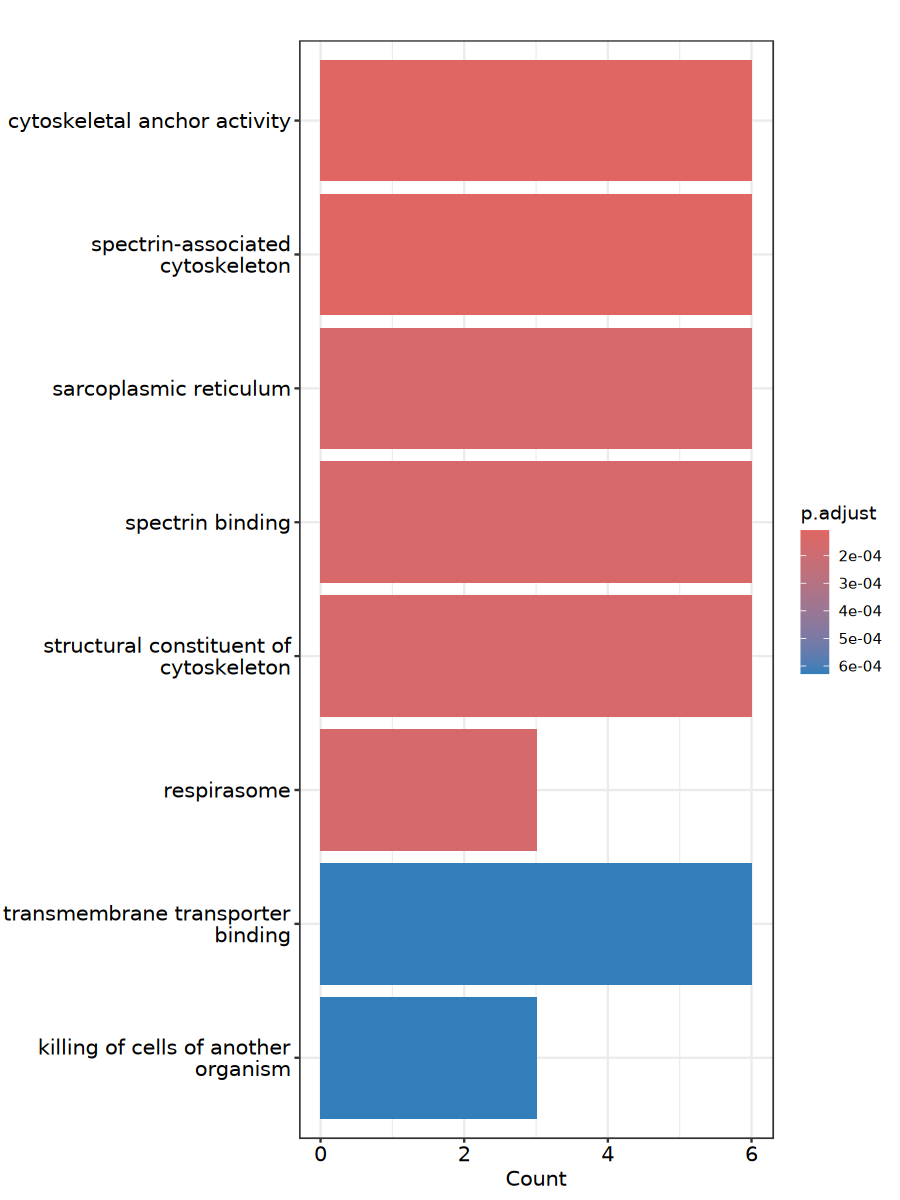

In [34]:
barplot(res_sig.wc.cw)

In [36]:
# HC vs. CH
res_sig.hc.ch <- enricher(
    gene = all_df$ch_hc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.hc.ch))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0031232,GO:0031232,extrinsic component of external side of plasma membrane,3/49,34/16641,0.0001346355,0.02919772,0.01959445,LOC111123495/LOC111104743/LOC111108101,3
GO:0009725,GO:0009725,response to hormone,3/49,47/16641,0.0003551450,0.02919772,0.01959445,LOC111104716/LOC111110558/LOC111110387,3
GO:0098632,GO:0098632,cell-cell adhesion mediator activity,2/49,10/16641,0.0003765067,0.02919772,0.01959445,LOC111125416/LOC111125415,2
GO:0062023,GO:0062023,collagen-containing extracellular matrix,6/49,344/16641,0.0004937195,0.02919772,0.01959445,LOC111105495/LOC111137636/LOC111104743/LOC111108101/LOC111111748/LOC111116035,6
GO:0005595,GO:0005595,collagen type XII trimer,2/49,12/16641,0.0005501353,0.02919772,0.01959445,LOC111105495/LOC111137636,2
GO:1904706,GO:1904706,negative regulation of vascular associated smooth muscle cell proliferation,2/49,13/16641,0.0006489379,0.02919772,0.01959445,LOC111110558/LOC111110387,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


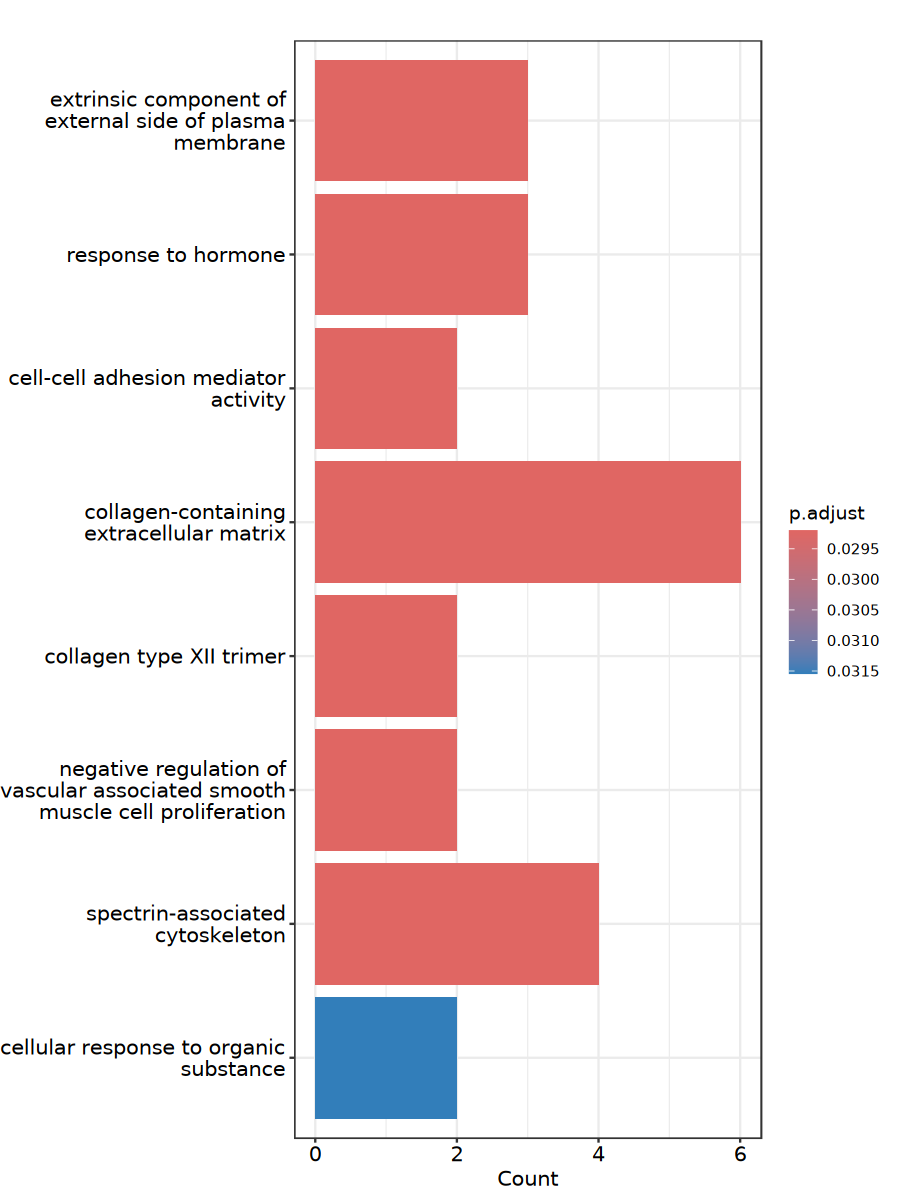

In [37]:
barplot(res_sig.hc.ch)

lots of signaling terms, some development (in terms of muscle cell proliferation), and some structural processes (cytoskeleton)

In [38]:
# BC vs. CB
res_sig.bc.cb <- enricher(
    gene = all_df$cb_bc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bc.cb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0001758,GO:0001758,retinal dehydrogenase activity,5/244,10/16641,1.544066e-07,0.0001588844,0.0001448172,LOC111128910/LOC111109438/LOC111109436/LOC111109441/LOC111109442,5
GO:0016298,GO:0016298,lipase activity,5/244,17/16641,3.485686e-06,0.0015969790,0.0014555862,LOC111118134/LOC111123216/LOC111134948/LOC111134947/LOC111103330,5
GO:0016042,GO:0016042,lipid catabolic process,9/244,86/16641,4.655915e-06,0.0015969790,0.0014555862,LOC111136736/LOC111118134/LOC111123216/LOC111134948/LOC111134947/LOC111137030/LOC111133423/LOC111103330/LOC111103450,9
GO:0005764,GO:0005764,lysosome,18/244,368/16641,8.643575e-06,0.0022235598,0.0020266910,LOC111109550/LOC111125505/LOC111119850/LOC111126259/LOC111125418/LOC111129386/LOC111128921/LOC111134948/LOC111134947/LOC111133671/LOC111103199/LOC111103198/LOC111103450/LOC111102947/LOC111109438/LOC111109436/LOC111109441/LOC111109442,18
GO:0002682,GO:0002682,regulation of immune system process,4/244,11/16641,1.372588e-05,0.0023539879,0.0021455713,LOC111133671/LOC111103199/LOC111103198/LOC111102947,4
GO:0010983,GO:0010983,positive regulation of high-density lipoprotein particle clearance,4/244,11/16641,1.372588e-05,0.0023539879,0.0021455713,LOC111120355/LOC111118284/LOC111118101/LOC111103330,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


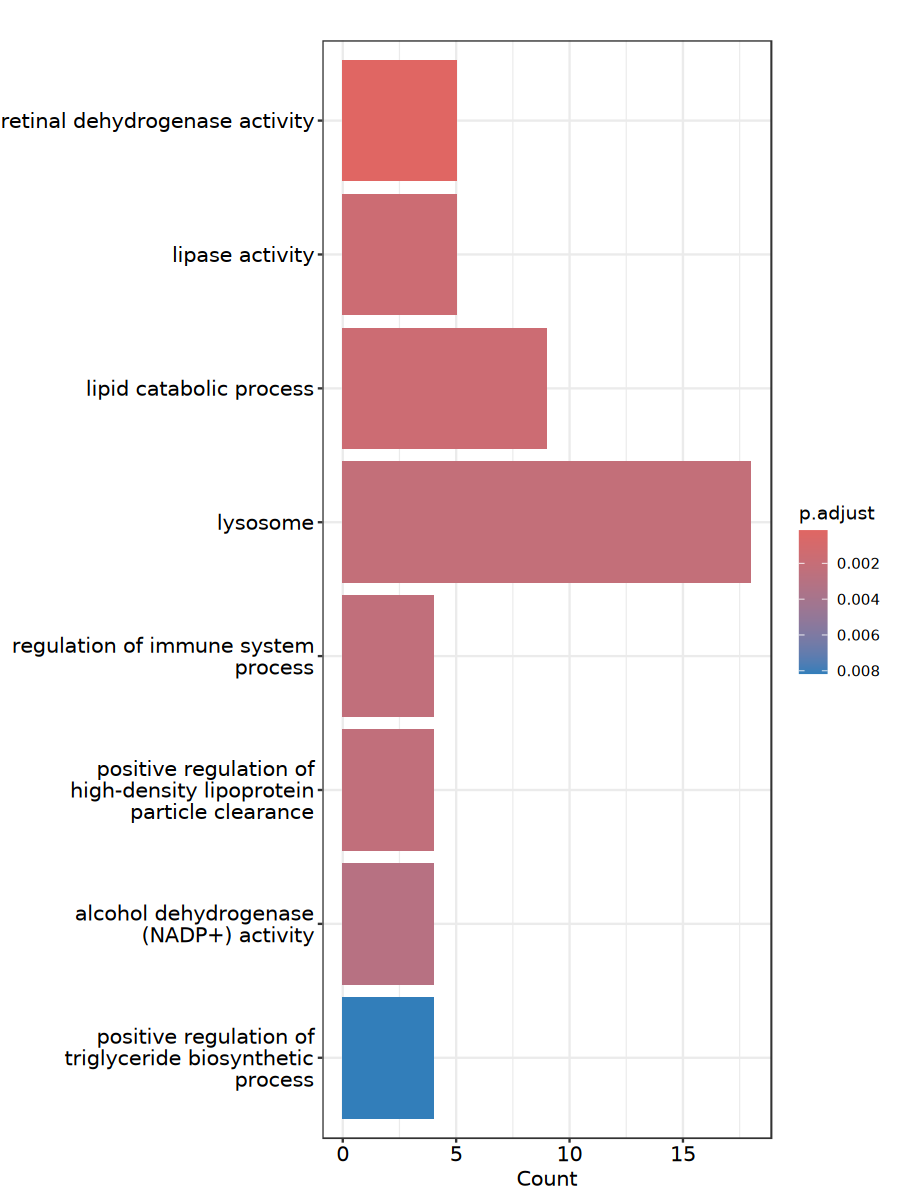

In [39]:
barplot(res_sig.bc.cb)

stress response (in terms of immune response genes) and metabolism (biosynthesis and catabolism)

lipase activity, lipid catabolic process, and lipoprotein are all enriched - lipids store energy, form cell membranes, act as signaling molecules

### 4. No stress vs. most stress
- CC vs. WW
- CC vs. HH
- CC vs. BB

In [9]:
# CC vs. WW
res_sig.cc.ww <- enricher(
    gene = all_df$ww_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.ww))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0044325,GO:0044325,transmembrane transporter binding,5/28,231/16641,3.737603e-05,0.01132494,0.00653097,LOC111100764/LOC111102130/LOC111108482/LOC111110117/LOC111113858,5
GO:0090314,GO:0090314,positive regulation of protein targeting to membrane,3/28,65/16641,1.737730e-04,0.02460638,0.01419024,LOC111100764/LOC111102130/LOC111108482,3
GO:0062023,GO:0062023,collagen-containing extracellular matrix,5/28,344/16641,2.436276e-04,0.02460638,0.01419024,LOC111105495/LOC111136853/LOC111129157/LOC111134917/LOC111104743,5
GO:0032433,GO:0032433,filopodium tip,2/28,21/16641,5.621013e-04,0.03341077,0.01926763,LOC111102130/LOC111109183,2
GO:0043005,GO:0043005,neuron projection,5/28,439/16641,7.432766e-04,0.03341077,0.01926763,LOC111100764/LOC111102130/LOC111108482/LOC111113858/LOC111110717,5
GO:0046847,GO:0046847,filopodium assembly,2/28,28/16641,1.004441e-03,0.03341077,0.01926763,LOC111109183/LOC111110717,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”
Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the enrichplot package.
  Please report the issue at
  <https://github.com/GuangchuangYu/enrichplot/issues>.”


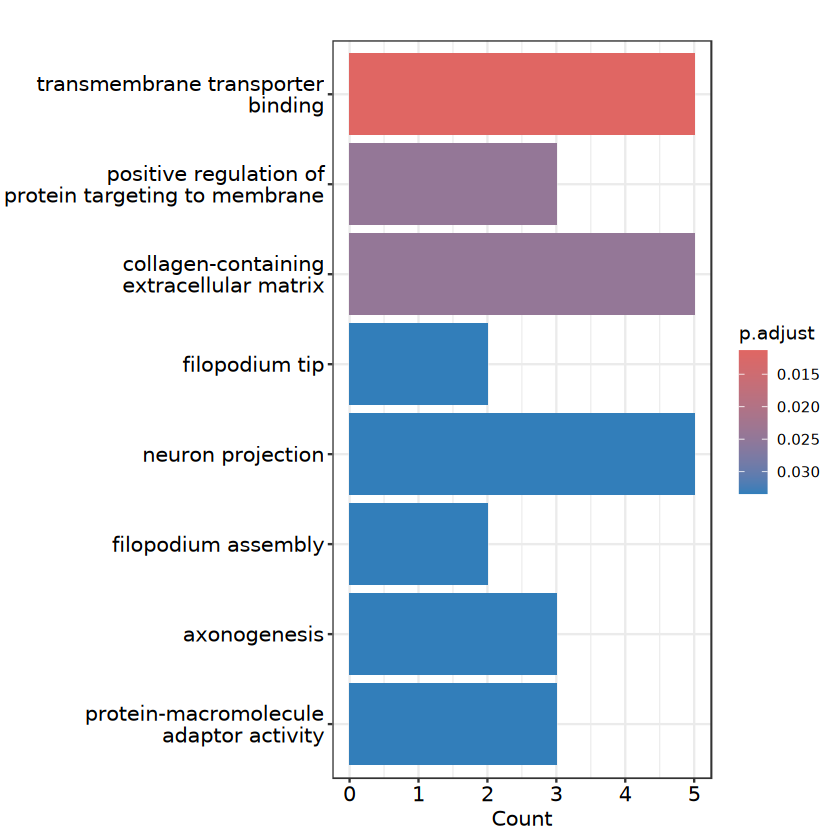

In [10]:
barplot(res_sig.cc.ww)

In [11]:
# CC vs. HH
res_sig.cc.hh <- enricher(
    gene = all_df$hh_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.hh))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004065,GO:0004065,arylsulfatase activity,6/257,16/16641,9.003881e-08,9.264994e-05,7.999238e-05,LOC111126258/LOC111126259/LOC111128443/LOC111129386/LOC111129385/LOC111135087,6
GO:0005764,GO:0005764,lysosome,20/257,368/16641,1.199833e-06,6.173142e-04,5.329786e-04,LOC111111564/LOC111118150/LOC111119850/LOC111126258/LOC111126259/LOC111125418/LOC111128443/LOC111129386/LOC111129385/LOC111129849/LOC111129848/LOC111134948/LOC111134947/LOC111135087/LOC111100764/LOC111103198/LOC111103450/LOC111108482/LOC111109438/LOC111109436,20
GO:0051597,GO:0051597,response to methylmercury,4/257,11/16641,1.683996e-05,5.776105e-03,4.986991e-03,LOC111126258/LOC111126259/LOC111128443/LOC111135087,4
GO:0106435,GO:0106435,carboxylesterase activity,5/257,23/16641,2.264473e-05,5.825358e-03,5.029514e-03,LOC111119661/LOC111118390/LOC111121705/LOC111113400/LOC111113411,5
GO:0009268,GO:0009268,response to pH,4/257,13/16641,3.560729e-05,7.327980e-03,6.326853e-03,LOC111126258/LOC111126259/LOC111128443/LOC111135087,4
GO:0004771,GO:0004771,sterol esterase activity,4/257,16/16641,8.738402e-05,1.284545e-02,1.109054e-02,LOC111121705/LOC111134948/LOC111134947/LOC111113400,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


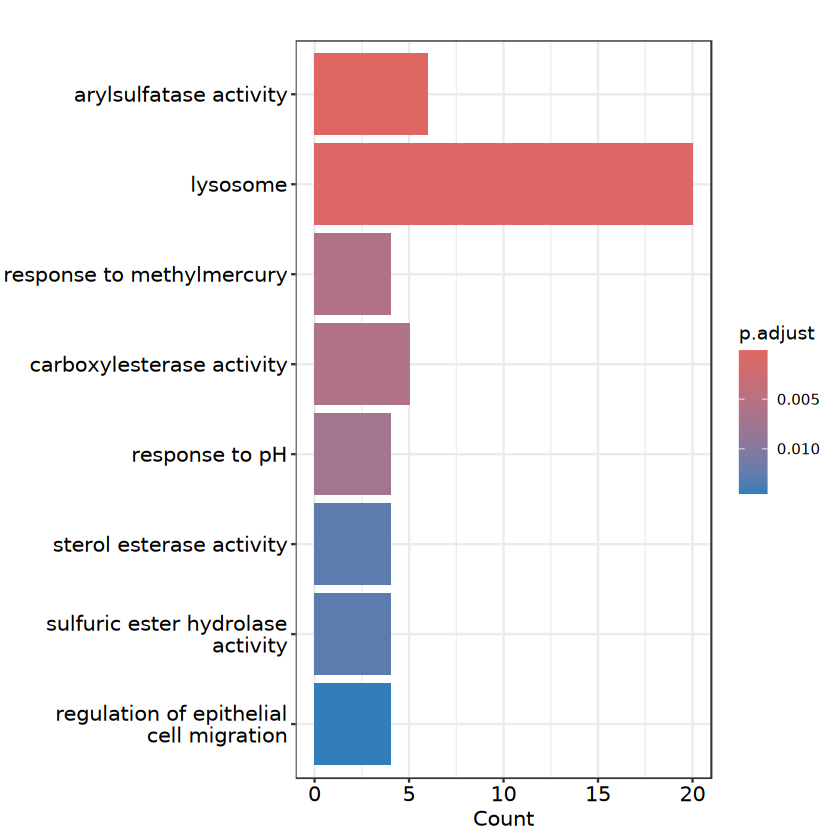

In [12]:
barplot(res_sig.cc.hh)

In [13]:
# CC vs. BB
res_sig.cc.bb <- enricher(
    gene = all_df$bb_cc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cc.bb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030507,GO:0030507,spectrin binding,5/44,161/16641,6.377843e-05,0.02302401,0.01523969,LOC111124681/LOC111100764/LOC111108482/LOC111106424/LOC111113858,5


### 5. Effect of initial exposure on response in later exposure

#### 5A. matched priming
- WW vs. CW
- HH vs. CH
- BB vs. CB

In [15]:
# WW vs. CW
res_sig.ww.cw <- enricher(
    gene = all_df$ww_cw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.ww.cw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0043005,GO:0043005,neuron projection,6/31,439/16641,0.0001369525,0.02753986,0.02017572,LOC111102130/LOC111107865/LOC111113858/LOC111110817/LOC111110717/LOC111116878,6
GO:0015132,GO:0015132,prostaglandin transmembrane transporter activity,2/31,16/16641,0.0003965220,0.02753986,0.02017572,LOC111131313/LOC111127793,2
GO:0015347,GO:0015347,sodium-independent organic anion transmembrane transporter activity,2/31,16/16641,0.0003965220,0.02753986,0.02017572,LOC111131313/LOC111127793,2
GO:0043252,GO:0043252,sodium-independent organic anion transport,2/31,17/16641,0.0004488702,0.02753986,0.02017572,LOC111131313/LOC111127793,2
GO:0015349,GO:0015349,thyroid hormone transmembrane transporter activity,2/31,18/16641,0.0005043931,0.02753986,0.02017572,LOC111131313/LOC111127793,2
GO:0008514,GO:0008514,organic anion transmembrane transporter activity,2/31,20/16641,0.0006249182,0.02843378,0.02083061,LOC111131313/LOC111127793,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


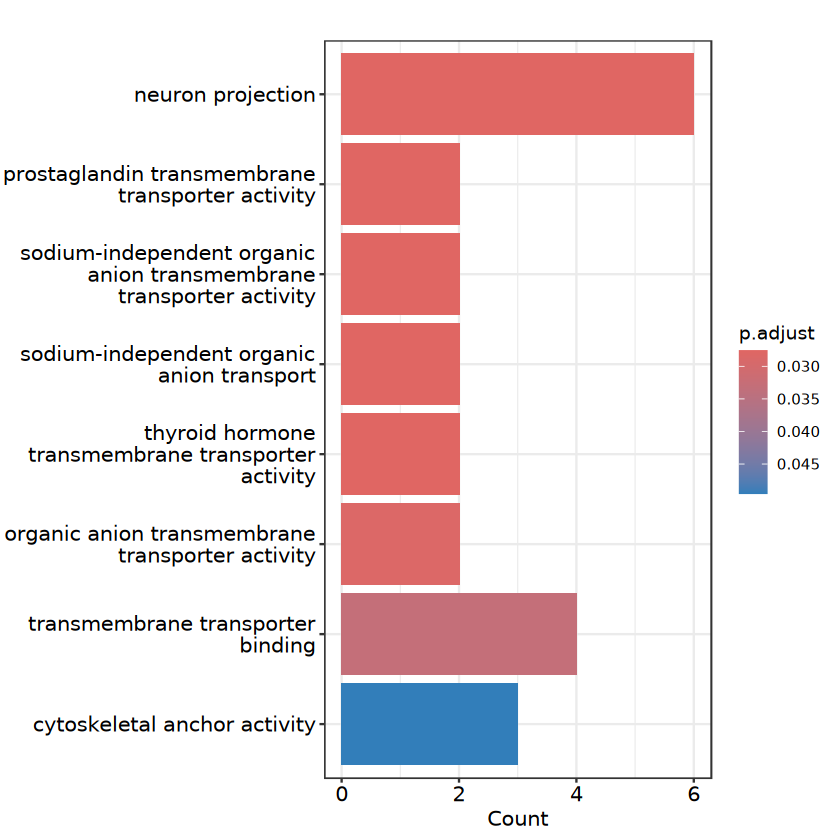

In [16]:
barplot(res_sig.ww.cw)

a lot of the terms are involved in transport - so cell signaling/communication?

In [17]:
# HH vs. CH
res_sig.hh.ch <- enricher(
    gene = all_df$hh_ch,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.hh.ch))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005764,GO:0005764,lysosome,23/311,368/16641,4.663125e-07,0.0006020094,0.0005306145,LOC111111564/LOC111119850/LOC111119429/LOC111120044/LOC111126258/LOC111126259/LOC111125418/LOC111123637/LOC111130612/LOC111129386/LOC111129385/LOC111129849/LOC111129848/LOC111134948/LOC111103199/LOC111103198/LOC111103450/LOC111108482/LOC111109438/LOC111109436/LOC111111341/LOC111116878/LOC111116556,23
GO:0016747,GO:0016747,"acyltransferase activity, transferring groups other than amino-acyl groups",5/311,12/16641,1.570202e-06,0.0010135652,0.0008933621,LOC111124814/LOC111125521/LOC111137913/LOC111137418/LOC111138175,5
GO:0050957,GO:0050957,equilibrioception,5/311,15/16641,5.684925e-06,0.0024464129,0.0021562822,LOC111121348/LOC111118035/LOC111118034/LOC111118039/LOC111118036,5
GO:0050953,GO:0050953,sensory perception of light stimulus,5/311,17/16641,1.135951e-05,0.0036662819,0.0032314817,LOC111121348/LOC111118035/LOC111118034/LOC111118039/LOC111118036,5
GO:0048563,GO:0048563,post-embryonic animal organ morphogenesis,4/311,10/16641,2.299281e-05,0.0059367432,0.0052326792,LOC111118035/LOC111118034/LOC111118039/LOC111118036,4
GO:0098683,GO:0098683,cochlear hair cell ribbon synapse,4/311,12/16641,5.261494e-05,0.0113209815,0.0099783775,LOC111118035/LOC111118034/LOC111118039/LOC111118036,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


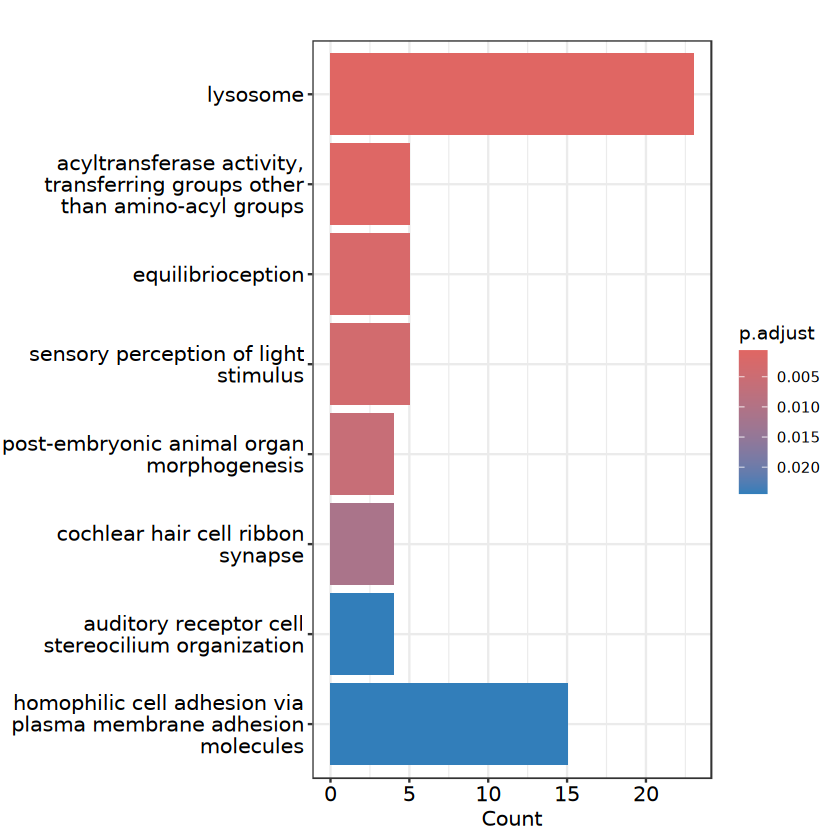

In [18]:
barplot(res_sig.hh.ch)

some terms involved in signaling, immune response, development

In [19]:
# BB vs. CB
res_sig.bb.cb <- enricher(
    gene = all_df$cb_bb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bb.cb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0007157,GO:0007157,heterophilic cell-cell adhesion via plasma membrane cell adhesion molecules,5/54,119/16641,4.108063e-05,0.01125609,0.008735039,LOC111129659/LOC111129664/LOC111106066/LOC111111776/LOC111117117,5
GO:0006887,GO:0006887,exocytosis,5/54,167/16641,2.037667e-04,0.02132197,0.016546439,LOC111134744/LOC111105268/LOC111106424/LOC111113824/LOC111113858,5
GO:0045199,GO:0045199,maintenance of epithelial cell apical/basal polarity,4/54,93/16641,2.334522e-04,0.02132197,0.016546439,LOC111105268/LOC111106424/LOC111113824/LOC111113858,4
GO:0031430,GO:0031430,M band,4/54,112/16641,4.745103e-04,0.02844338,0.022072852,LOC111105268/LOC111106424/LOC111113824/LOC111113858,4
GO:0008093,GO:0008093,cytoskeletal anchor activity,4/54,121/16641,6.352282e-04,0.02844338,0.022072852,LOC111105268/LOC111106424/LOC111113824/LOC111113858,4
GO:0005198,GO:0005198,structural molecule activity,4/54,123/16641,6.755980e-04,0.02844338,0.022072852,LOC111105268/LOC111106424/LOC111113824/LOC111113858,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


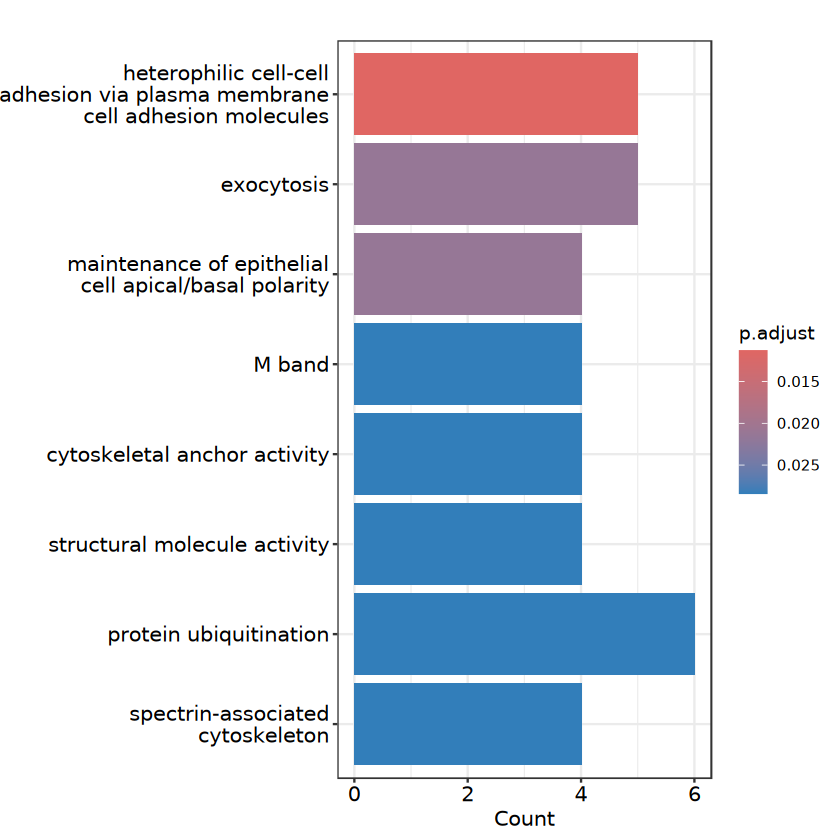

In [20]:
barplot(res_sig.bb.cb)

terns involved in structural processes

#### 5B. semi-matched priming: in context of later single stress
- CH vs. BH
- CW vs. BW

In [21]:
# CH vs. BH
res_sig.ch.bh <- enricher(
    gene = all_df$bh_ch,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.ch.bh))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0030199,GO:0030199,collagen fibril organization,4/92,43/16641,9.153866e-05,0.04888165,0.04528755,LOC111105495/LOC111123816/LOC111137636/LOC111109250,4


In [22]:
# CW vs. BW
res_sig.cw_bw <- enricher(
    gene = all_df$bw_cw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cw_bw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016491,GO:0016491,oxidoreductase activity,6/43,182/16641,6.865153e-06,0.001723153,0.001387484,LOC111137386/LOC111133989/LOC111136642/LOC111136225/LOC111104019/LOC111106942,6


#### 5C. semi matched priming: in context of later multiple stress
- CB vs. WB
- CB vs. HB

In [23]:
# CB vs. WB
res_sig.wb.cb <- enricher(
    gene = all_df$wb_cb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wb.cb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015969,GO:0015969,guanosine tetraphosphate metabolic process,6/55,29/16641,4.409114e-10,1.781282e-07,1.355222e-07,LOC111109405/LOC111108435/LOC111107391/LOC111108877/LOC111108387/LOC111110716,6
GO:0007342,GO:0007342,fusion of sperm to egg plasma membrane involved in single fertilization,3/55,17/16641,2.248136e-05,4.541236e-03,3.455031e-03,LOC111121853/LOC111115657/LOC111114598,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


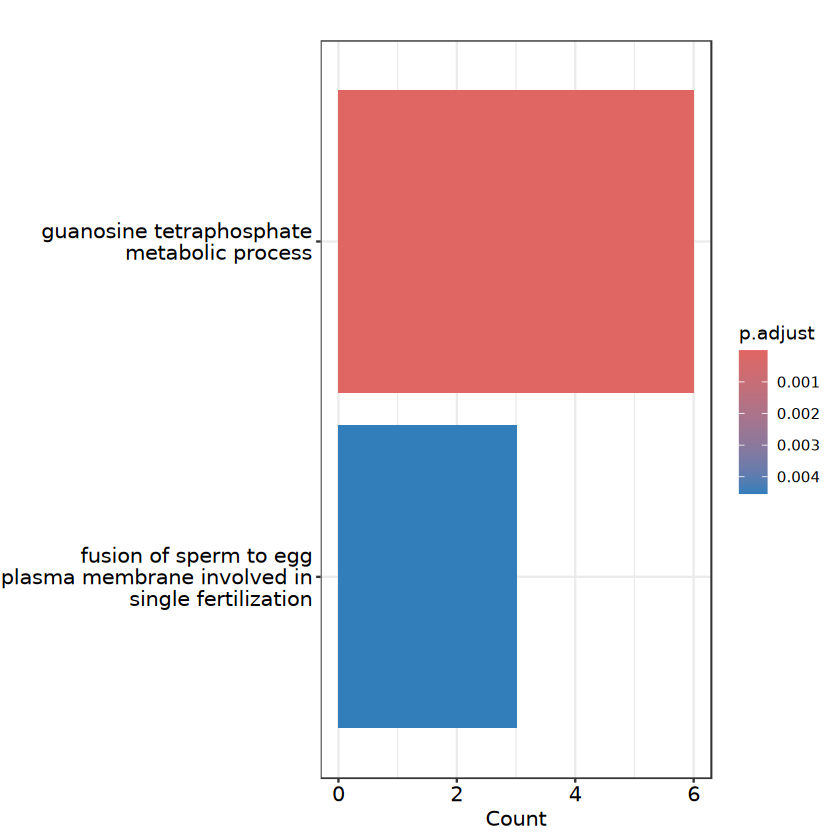

In [24]:
barplot(res_sig.wb.cb)

In [25]:
# CB vs. HB
res_sig.cb.hb <- enricher(
    gene = all_df$hb_cb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cb.hb))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched terms

### 6. Effect of initial exposure on subsequent response to stress
- WW vs. WC
- HH vs. HC
- BB vs. BC

In [26]:
# WW vs. WC
res_sig.wc.ww <- enricher(
    gene = all_df$wc_ww,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wc.ww))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014719,GO:0014719,skeletal muscle satellite cell activation,4/42,110/16641,0.0001667017,0.01852772,0.01211358,LOC111111776/LOC111114999/LOC111112501/LOC111117004,4
GO:0014841,GO:0014841,skeletal muscle satellite cell proliferation,4/42,110/16641,0.0001667017,0.01852772,0.01211358,LOC111111776/LOC111114999/LOC111112501/LOC111117004,4
GO:0014816,GO:0014816,skeletal muscle satellite cell differentiation,4/42,111/16641,0.0001726185,0.01852772,0.01211358,LOC111111776/LOC111114999/LOC111112501/LOC111117004,4
GO:0005595,GO:0005595,collagen type XII trimer,2/42,12/16641,0.0004039089,0.03069195,0.02006665,LOC111105495/LOC111137636,2
GO:0070469,GO:0070469,respirasome,2/42,13/16641,0.0004765830,0.03069195,0.02006665,LOC111119097/LOC111119236,2
GO:0090314,GO:0090314,positive regulation of protein targeting to membrane,3/42,65/16641,0.0005856518,0.03142998,0.02054919,LOC111100764/LOC111102130/LOC111112084,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


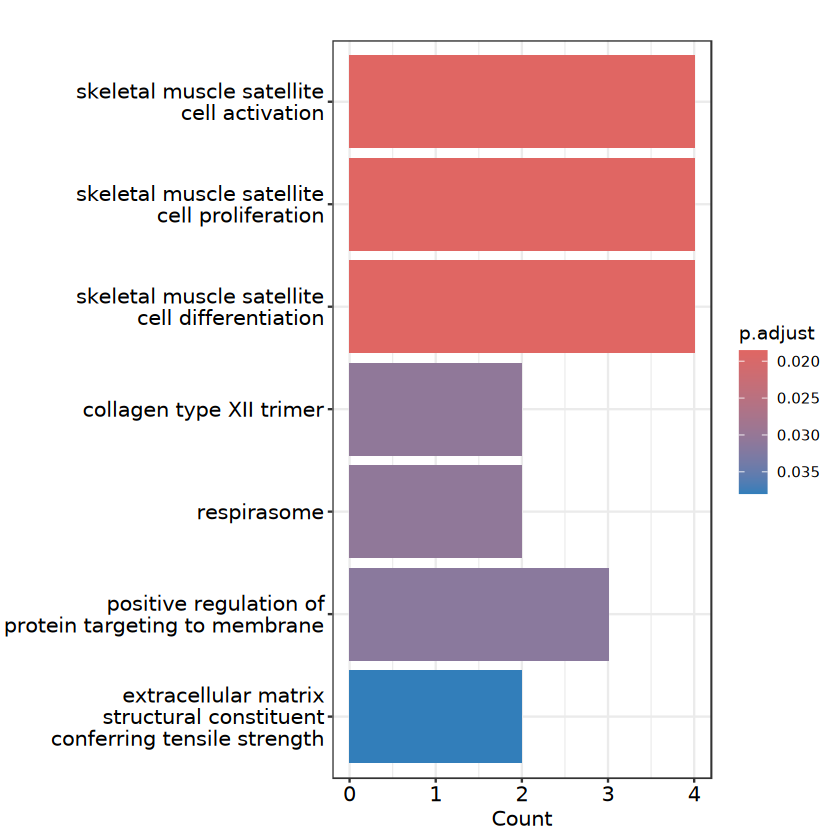

In [27]:
barplot(res_sig.wc.ww)

see terms for developmental and structural processes

In [29]:
# HH vs. HC
res_sig.hh.hc <- enricher(
    gene = all_df$hc_hh,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.hh.hc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005764,GO:0005764,lysosome,23/311,368/16641,4.663125e-07,0.000574497,0.0005237426,LOC111111564/LOC111125505/LOC111121750/LOC111118150/LOC111119850/LOC111126258/LOC111126259/LOC111125418/LOC111122564/LOC111129386/LOC111129385/LOC111129849/LOC111129848/LOC111132893/LOC111134948/LOC111134947/LOC111135087/LOC111100764/LOC111103199/LOC111103198/LOC111103450/LOC111109438/LOC111109623,23
GO:0016042,GO:0016042,lipid catabolic process,10/311,86/16641,4.539044e-06,0.002796051,0.0025490313,LOC111136736/LOC111121750/LOC111118390/LOC111123216/LOC111126108/LOC111134948/LOC111134947/LOC111133423/LOC111103330/LOC111103450,10
GO:0004065,GO:0004065,arylsulfatase activity,5/311,16/16641,8.142741e-06,0.003343952,0.0030485279,LOC111126258/LOC111126259/LOC111129386/LOC111129385/LOC111135087,5
GO:0005365,GO:0005365,myo-inositol transmembrane transporter activity,4/311,11/16641,3.560003e-05,0.008771847,0.0079968905,LOC111123075/LOC111123072/LOC111108267/LOC111107140,4
GO:0010983,GO:0010983,positive regulation of high-density lipoprotein particle clearance,4/311,11/16641,3.560003e-05,0.008771847,0.0079968905,LOC111120355/LOC111118284/LOC111118101/LOC111103330,4
GO:0015798,GO:0015798,myo-inositol transport,4/311,12/16641,5.261494e-05,0.010803601,0.0098491478,LOC111123075/LOC111123072/LOC111108267/LOC111107140,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


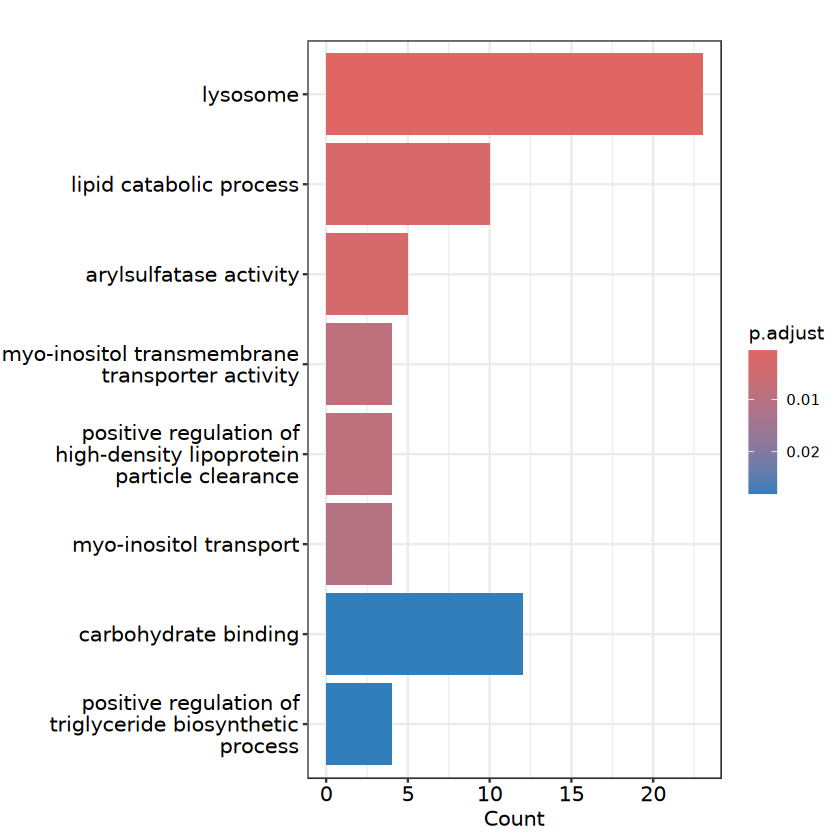

In [30]:
barplot(res_sig.hh.hc)

stress response, metabolism

In [31]:
# BB vs. BC
res_sig.bb_bc <- enricher(
    gene = all_df$bc_bb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bb_bc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005275,GO:0005275,amine transmembrane transporter activity,4/148,11/16641,1.888620e-06,0.0009917192,0.0008785423,LOC111124745/LOC111111181/LOC111115947/LOC111114779,4
GO:0015827,GO:0015827,tryptophan transport,4/148,13/16641,4.035639e-06,0.0009917192,0.0008785423,LOC111124745/LOC111111181/LOC111115947/LOC111114779,4
GO:0032217,GO:0032217,riboflavin transmembrane transporter activity,4/148,14/16641,5.610858e-06,0.0009917192,0.0008785423,LOC111133005/LOC111111181/LOC111115947/LOC111114779,4
GO:0032218,GO:0032218,riboflavin transport,4/148,14/16641,5.610858e-06,0.0009917192,0.0008785423,LOC111133005/LOC111111181/LOC111115947/LOC111114779,4
GO:0001758,GO:0001758,retinal dehydrogenase activity,3/148,10/16641,7.902070e-05,0.0077764127,0.0068889534,LOC111128910/LOC111109438/LOC111109442,3
GO:0006727,GO:0006727,ommochrome biosynthetic process,3/148,10/16641,7.902070e-05,0.0077764127,0.0068889534,LOC111111181/LOC111115947/LOC111114779,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


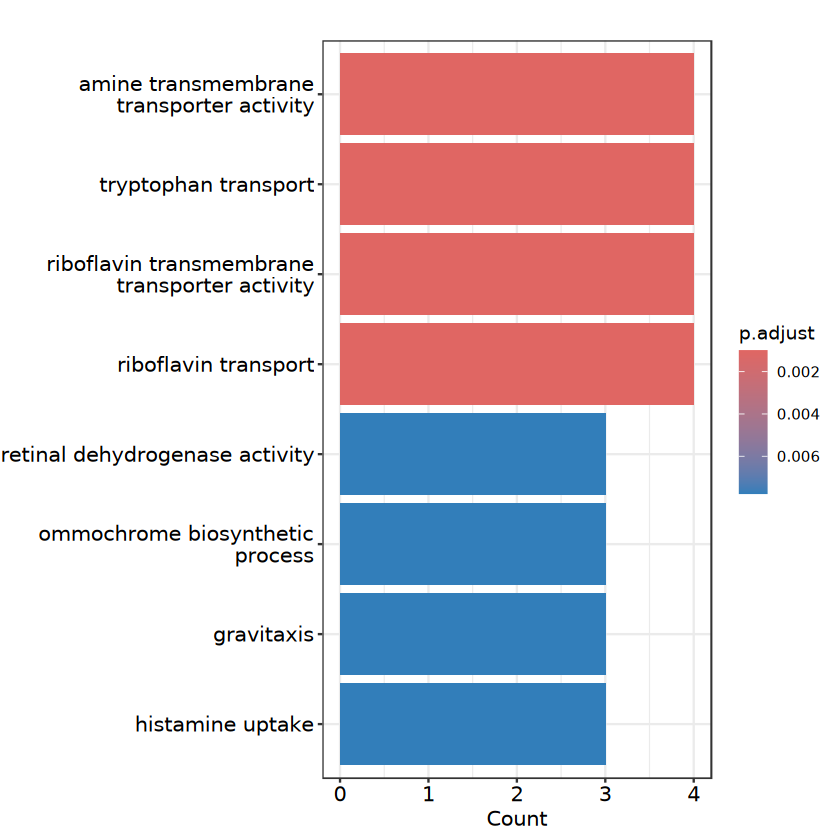

In [32]:
barplot(res_sig.bb_bc)

### 7. Effect of initial single/multiple stress on response in ...

#### 7A. ...later single stress
- BH vs. HH
- BW vs. WW

In [33]:
# BH vs. HH
res_sig.bh_hh <- enricher(
    gene = all_df$bh_hh,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bh_hh))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004065,GO:0004065,arylsulfatase activity,5/322,16/16641,9.639786e-06,0.004866573,0.004377115,LOC111126258/LOC111126259/LOC111129386/LOC111129385/LOC111135087,5
GO:0004771,GO:0004771,sterol esterase activity,5/322,16/16641,9.639786e-06,0.004866573,0.004377115,LOC111121705/LOC111134948/LOC111134947/LOC111112314/LOC111113400,5
GO:0005764,GO:0005764,lysosome,21/322,368/16641,1.057185e-05,0.004866573,0.004377115,LOC111125529/LOC111125505/LOC111119850/LOC111126258/LOC111126259/LOC111125418/LOC111122563/LOC111123637/LOC111128277/LOC111129386/LOC111129385/LOC111129849/LOC111134948/LOC111134947/LOC111135087/LOC111133671/LOC111135837/LOC111101645/LOC111103450/LOC111109438/LOC111107865,21
GO:0004601,GO:0004601,peroxidase activity,7/322,42/16641,1.434753e-05,0.004953485,0.004455286,LOC111101430/LOC111136982/LOC111127033/LOC111102674/LOC111123816/LOC111125681/LOC111132595,7
GO:0016324,GO:0016324,apical plasma membrane,20/322,398/16641,1.019031e-04,0.027194319,0.024459237,LOC111125529/LOC111125505/LOC111099678/LOC111119149/LOC111123368/LOC111130917/LOC111118627/LOC111119178/LOC111125414/LOC111123075/LOC111123072/LOC111122563/LOC111123637/LOC111131510/LOC111128741/LOC111135175/LOC111136939/LOC111107140/LOC111108705/LOC111116803,20
GO:0010897,GO:0010897,negative regulation of triglyceride catabolic process,4/322,14/16641,1.181506e-04,0.027194319,0.024459237,LOC111120355/LOC111118284/LOC111118101/LOC111099965,4


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


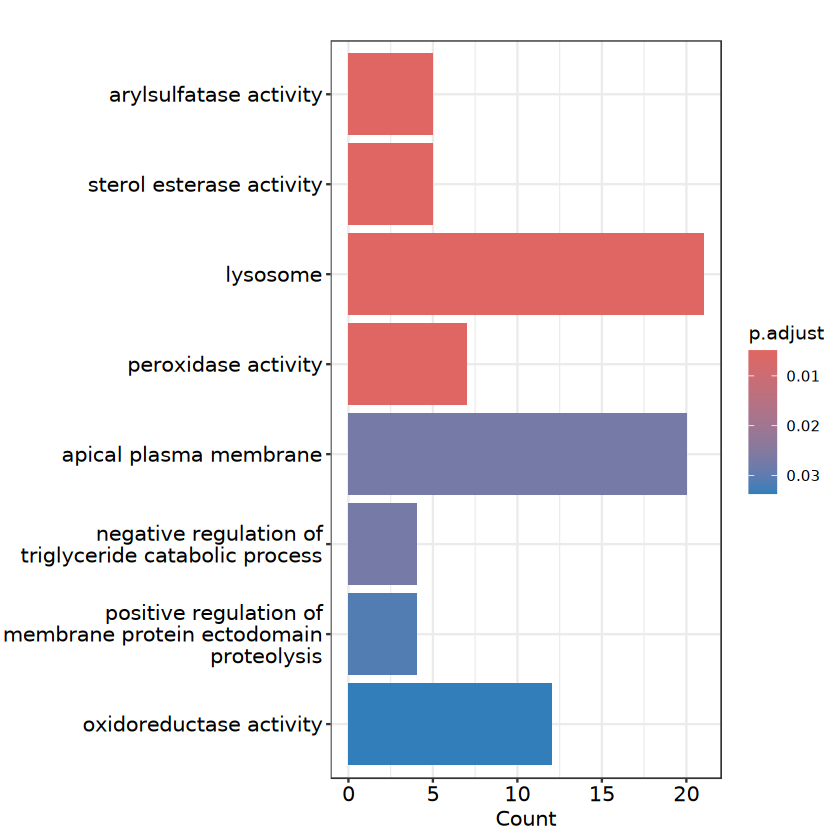

In [34]:
barplot(res_sig.bh_hh)

In [35]:
# BW vs. WW
res_sig.bw.ww <- enricher(
    gene = all_df$bw_ww,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bw.ww))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016491,GO:0016491,oxidoreductase activity,5/44,182/16641,0.0001138298,0.03039257,0.02348489,LOC111137386/LOC111136642/LOC111136225/LOC111104019/LOC111106942,5


oxidoreductase activity seems to come up a lot

#### 7B. ...later multiple stressors
- HB vs. BB
- WB vs. BB

In [36]:
# HB vs. BB
res_sig.hb.bb <- enricher(
    gene = all_df$hb_bb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.hb.bb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0008584,GO:0008584,male gonad development,3/39,43/16641,0.0001376449,0.0367512,0.03100634,LOC111122111/LOC111110547/LOC111108308,3


... interesting?

In [37]:
# WB vs. BB
res_sig.wb.bb <- enricher(
    gene = all_df$wb_bb,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wb.bb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015969,GO:0015969,guanosine tetraphosphate metabolic process,7/32,29/16641,7.287566e-14,2.15712e-11,1.442171e-11,LOC111109405/LOC111108435/LOC111107388/LOC111107391/LOC111107389/LOC111108877/LOC111108387,7


### 8. Shared/unique responses among stressors with ...

#### 8A. different early stressors
- WC vs. HC
- BC vs. HC
- BC vs. WC

In [38]:
# WC vs. HC
res_sig.wc.hc <- enricher(
    gene = all_df$wc_hc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wc.hc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0031232,GO:0031232,extrinsic component of external side of plasma membrane,3/46,34/16641,0.000111395,0.02996524,0.02263076,LOC111123495/LOC111104743/LOC111108101,3


In [39]:
# BC vs. HC
res_sig.bc.hc <- enricher(
    gene = all_df$bc_hc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bc.hc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005764,GO:0005764,lysosome,20/232,368/16641,2.356707e-07,0.0002434478,0.0002123517,LOC111111564/LOC111125529/LOC111125505/LOC111121750/LOC111119850/LOC111126259/LOC111125418/LOC111129386/LOC111129849/LOC111128921/LOC111132893/LOC111134948/LOC111134947/LOC111135087/LOC111100764/LOC111103198/LOC111103450/LOC111109438/LOC111109436/LOC111109623,20
GO:0016042,GO:0016042,lipid catabolic process,9/232,86/16641,3.085280e-06,0.0015935469,0.0013899996,LOC111136736/LOC111121750/LOC111118390/LOC111123216/LOC111134948/LOC111134947/LOC111133423/LOC111103330/LOC111103450,9
GO:0016298,GO:0016298,lipase activity,4/232,17/16641,7.596186e-05,0.0261561991,0.0228152101,LOC111123216/LOC111134948/LOC111134947/LOC111103330,4
GO:0070555,GO:0070555,response to interleukin-1,4/232,19/16641,1.210268e-04,0.0264092322,0.0230359227,LOC111119069/LOC111128901/LOC111132893/LOC111105271,4
GO:0016853,GO:0016853,isomerase activity,4/232,20/16641,1.496354e-04,0.0264092322,0.0230359227,LOC111122412/LOC111129010/LOC111129331/LOC111104956,4
GO:0005777,GO:0005777,peroxisome,9/232,140/16641,1.533934e-04,0.0264092322,0.0230359227,LOC111113840/LOC111118059/LOC111122381/LOC111130119/LOC111129331/LOC111108763/LOC111107492/LOC111107606/LOC111115883,9


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


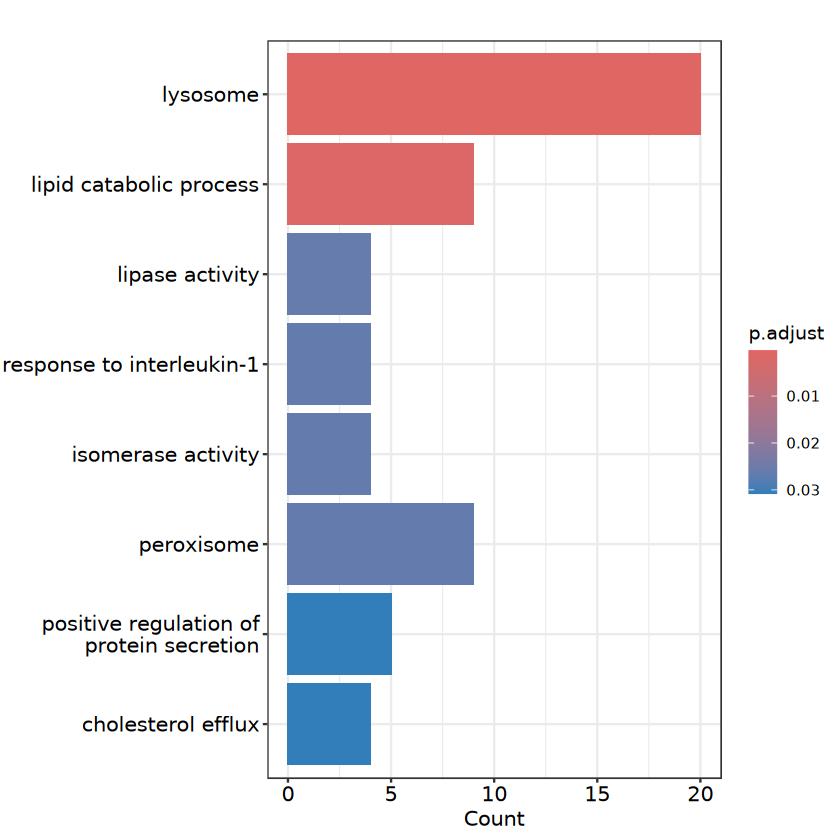

In [40]:
barplot(res_sig.bc.hc)

lot of terms related to immune response (so stress response)

In [41]:
# BC vs. WC
res_sig.bc.wc <- enricher(
    gene = all_df$bc_wc,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bc.wc))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0005764,GO:0005764,lysosome,20/161,368/16641,4.486182e-10,4.181122e-07,3.877006e-07,LOC111109550/LOC111123884/LOC111125529/LOC111127502/LOC111121750/LOC111119850/LOC111119429/LOC111126258/LOC111129386/LOC111129385/LOC111128921/LOC111132893/LOC111134948/LOC111135238/LOC111100764/LOC111103199/LOC111103842/LOC111103450/LOC111109438/LOC111111341,20


immune response!

#### 8B. different late stressors
- CW vs. CH
- CB vs. CH (no enriched terms)
- CW vs. CB (no enriched terms)

In [42]:
# CW vs. CH
res_sig.cw.ch <- enricher(
    gene = all_df$cw_ch,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cw.ch))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0014731,GO:0014731,spectrin-associated cytoskeleton,7/51,135/16641,1.700722e-07,5.799461e-05,4.260756e-05,LOC111101858/LOC111104605/LOC111108482/LOC111107865/LOC111113824/LOC111113858/LOC111110817,7
GO:0016529,GO:0016529,sarcoplasmic reticulum,7/51,154/16641,4.172305e-07,6.152712e-05,4.520282e-05,LOC111101858/LOC111104605/LOC111108482/LOC111107865/LOC111113824/LOC111113858/LOC111110817,7
GO:0030507,GO:0030507,spectrin binding,7/51,161/16641,5.637670e-07,6.152712e-05,4.520282e-05,LOC111101858/LOC111104605/LOC111108482/LOC111107865/LOC111113824/LOC111113858/LOC111110817,7
GO:0005200,GO:0005200,structural constituent of cytoskeleton,7/51,167/16641,7.217257e-07,6.152712e-05,4.520282e-05,LOC111101858/LOC111104605/LOC111108482/LOC111107865/LOC111113824/LOC111113858/LOC111110817,7
GO:0008093,GO:0008093,cytoskeletal anchor activity,6/51,121/16641,1.798440e-06,1.226536e-04,9.011133e-05,LOC111101858/LOC111104605/LOC111107865/LOC111113824/LOC111113858/LOC111110817,6
GO:0044325,GO:0044325,transmembrane transporter binding,7/51,231/16641,6.244979e-06,3.549230e-04,2.607553e-04,LOC111101858/LOC111104605/LOC111108482/LOC111107865/LOC111113824/LOC111113858/LOC111110817,7


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


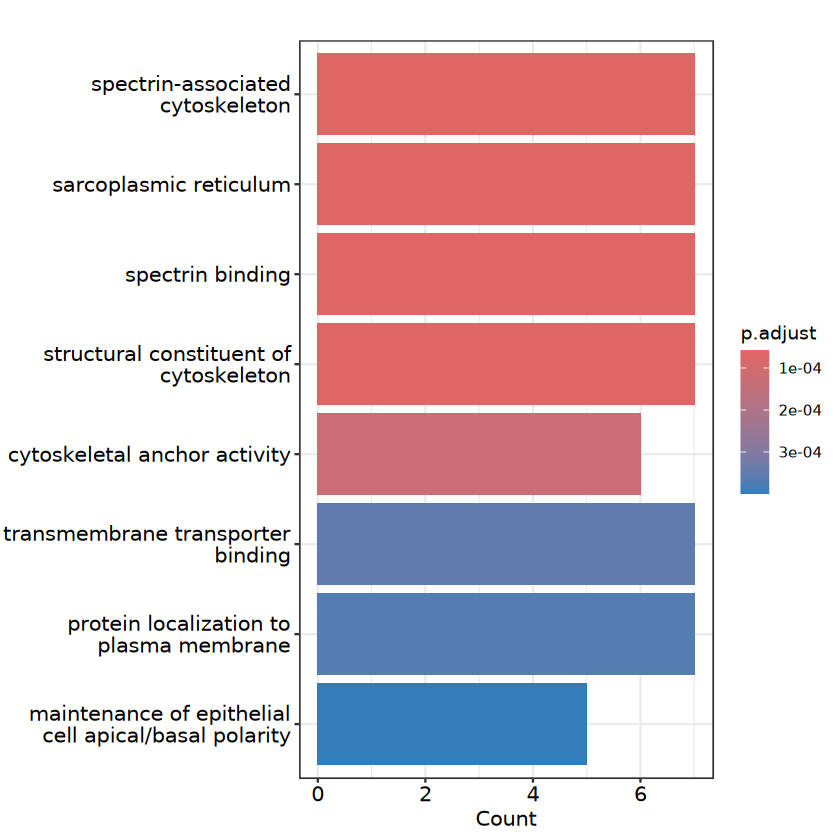

In [43]:
barplot(res_sig.cw.ch)

terms invovled in structural processes (cytoskeleton)

In [44]:
# CB vs. CH
res_sig.cb.ch <- enricher(
    gene = all_df$cb_ch,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cb.ch))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched terms

In [47]:
# CB vs. CW
res_sig.cb.cw <- enricher(
    gene = all_df$cb_cw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.cb.cw))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>


no enriched terms

### 9. Effect of order of stresses on GE
- WH vs. HW
- WB vs. BW
- HB vs. BH

In [48]:
# WH vs. HW
res_sig.wh.hw <- enricher(
    gene = all_df$wh_hw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.wh.hw))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006031,GO:0006031,chitin biosynthetic process,2/44,17/16641,0.0009060839,0.04335118,0.03642056,LOC111125341/LOC111128135,2
GO:0006038,GO:0006038,cell wall chitin biosynthetic process,2/44,17/16641,0.0009060839,0.04335118,0.03642056,LOC111125341/LOC111128135,2
GO:0030428,GO:0030428,cell septum,2/44,17/16641,0.0009060839,0.04335118,0.03642056,LOC111125341/LOC111128135,2
GO:0048873,GO:0048873,homeostasis of number of cells within a tissue,2/44,18/16641,0.0010176333,0.04335118,0.03642056,LOC111110547/LOC111108308,2
GO:0061063,GO:0061063,positive regulation of nematode larval development,2/44,18/16641,0.0010176333,0.04335118,0.03642056,LOC111125341/LOC111128135,2
GO:0004100,GO:0004100,chitin synthase activity,2/44,21/16641,0.0013897321,0.04933549,0.04144815,LOC111125341/LOC111128135,2


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


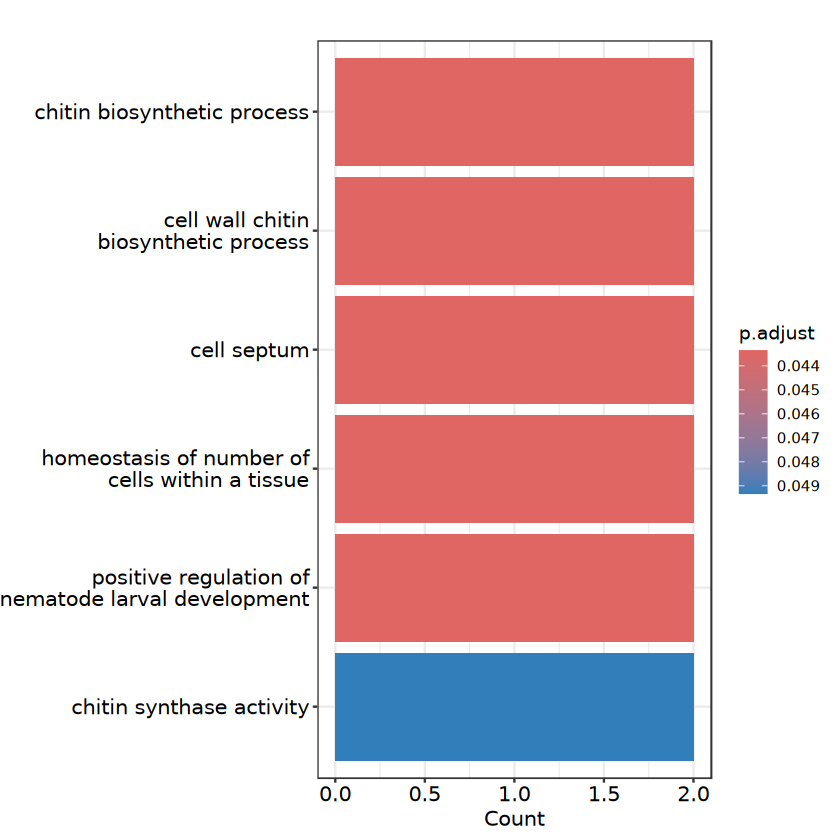

In [49]:
barplot(res_sig.wh.hw)

interesting that chitin shows up again!!

In [51]:
# BW vs. WB
res_sig.bw.wb <- enricher(
    gene = all_df$wb_bw,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bw.wb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015969,GO:0015969,guanosine tetraphosphate metabolic process,5/48,29/16641,1.816793e-08,5.722899e-06,4.264683e-06,LOC111109405/LOC111108435/LOC111107391/LOC111108877/LOC111108387,5
GO:0016491,GO:0016491,oxidoreductase activity,5/48,182/16641,1.732479e-04,2.728655e-02,2.033384e-02,LOC111137386/LOC111136642/LOC111136012/LOC111104019/LOC111106942,5
GO:0008345,GO:0008345,larval locomotory behavior,3/48,51/16641,4.255801e-04,4.468591e-02,3.329978e-02,LOC111107272/LOC111115548/LOC111117328,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


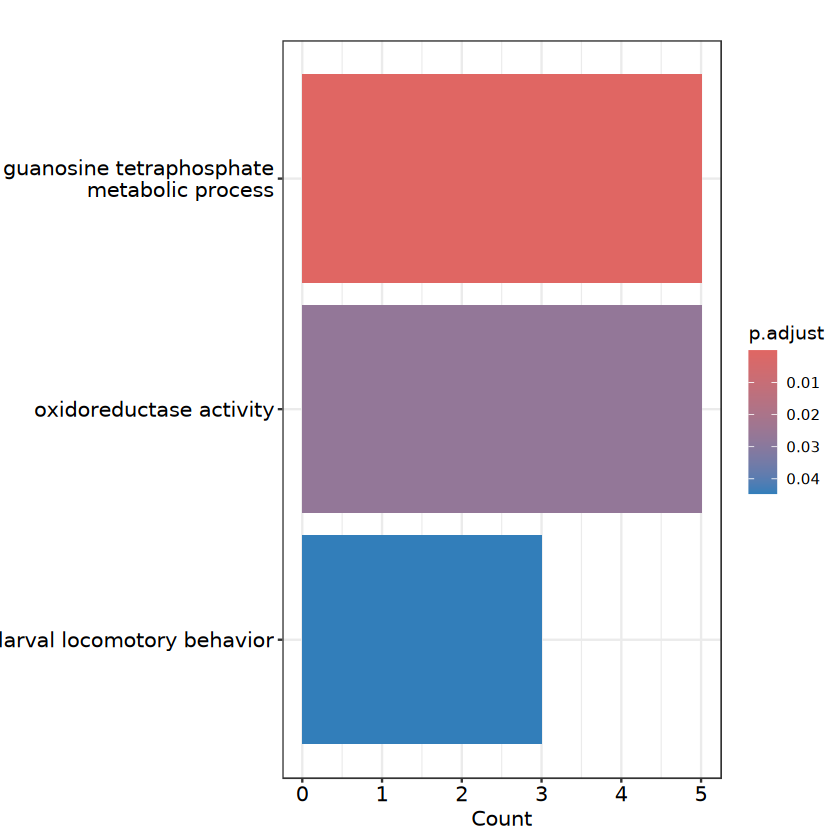

In [52]:
barplot(res_sig.bw.wb)

In [54]:
# BH vs. HB
res_sig.bh.hb <- enricher(
    gene = all_df$hb_bh,
    TERM2GENE = term2gene,
    TERM2NAME = term2name,
    pvalueCutoff = 0.05,
    pAdjustMethod = "BH",
    universe = universal)

head(as.data.frame(res_sig.bh.hb))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004601,GO:0004601,peroxidase activity,5/101,42/16641,5.305702e-06,0.002785493,0.002636096,LOC111101430/LOC111099775/LOC111123816/LOC111104184/LOC111103001,5
GO:0004500,GO:0004500,dopamine beta-monooxygenase activity,3/101,15/16641,9.364103e-05,0.012137751,0.011486754,LOC111122967/LOC111127803/LOC111127802,3
GO:0006589,GO:0006589,octopamine biosynthetic process,3/101,16/16641,1.147429e-04,0.012137751,0.011486754,LOC111122967/LOC111127803/LOC111127802,3
GO:0042420,GO:0042420,dopamine catabolic process,3/101,16/16641,1.147429e-04,0.012137751,0.011486754,LOC111122967/LOC111127803/LOC111127802,3
GO:0042421,GO:0042421,norepinephrine biosynthetic process,3/101,17/16641,1.387172e-04,0.012137751,0.011486754,LOC111122967/LOC111127803/LOC111127802,3
GO:0140825,GO:0140825,lactoperoxidase activity,3/101,17/16641,1.387172e-04,0.012137751,0.011486754,LOC111123816/LOC111104184/LOC111103001,3


Warning message in fortify(object, showCategory = showCategory, by = x, ...):
“Arguments in `...` must be used.
✖ Problematic argument:
• by = x
ℹ Did you misspell an argument name?”


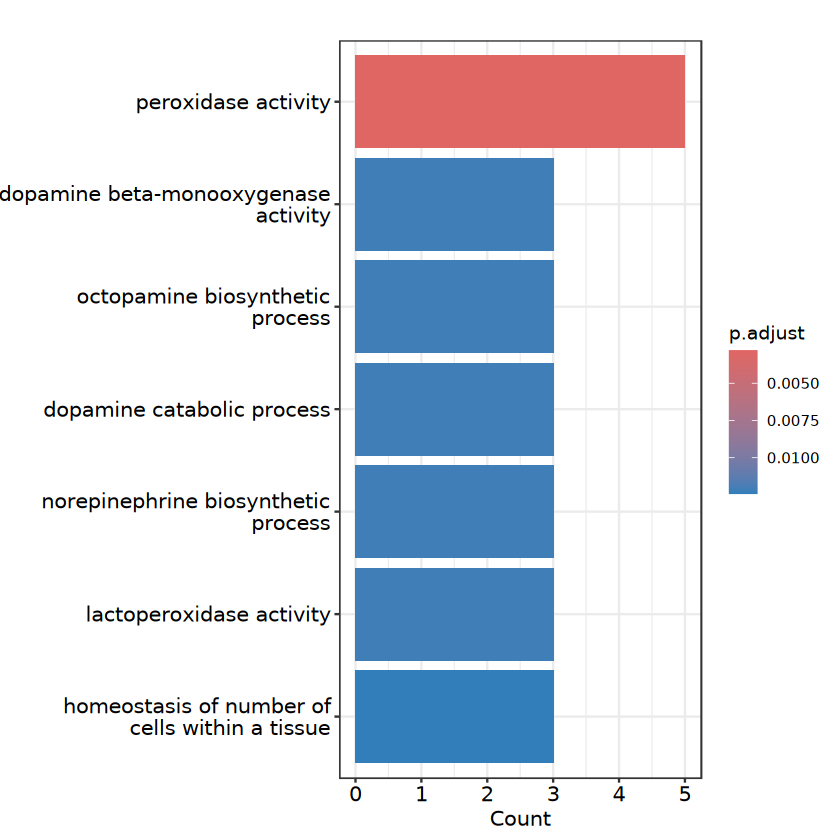

In [55]:
barplot(res_sig.bh.hb)

terms associated with metabolic processes (biosynthetic and catabolism)